## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../mouth_year.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,7.461290,143.0,210.0,1.72,218.0,94.6,0.434,1.885252,3.612903,72.773750,...,90.400000,1017.477354,1013.751613,1021.354839,213.224691,148.193548,273.870968,5.215817,3.112903,7.035484
1,3.100000,143.0,210.0,1.72,218.0,94.6,0.434,2.395833,4.000000,72.791667,...,90.600000,1017.168750,1015.500000,1021.000000,227.041667,192.000000,283.000000,4.781250,2.600000,7.400000
2,30.171429,143.0,210.0,1.72,218.0,94.6,0.434,5.704613,11.500000,120.002232,...,87.157143,1024.363914,1021.210714,1027.460714,179.183036,127.214286,233.535714,4.203720,2.382143,6.142857
3,39.050000,143.0,210.0,1.72,218.0,94.6,0.434,6.229167,12.000000,117.760417,...,90.050000,1026.685417,1023.400000,1030.000000,191.343750,154.000000,217.000000,3.611458,1.450000,5.500000
4,26.516129,143.0,210.0,1.72,218.0,94.6,0.434,8.653686,12.870968,189.389254,...,85.245161,1020.149565,1016.722581,1023.654839,180.347464,125.225806,232.806452,6.274361,3.974194,8.567742


In [2]:
df.shape

(726, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((702, 24, 34), (702,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((580, 24, 34), (580,), (73, 24, 34), (73,), (49, 24, 34), (49,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

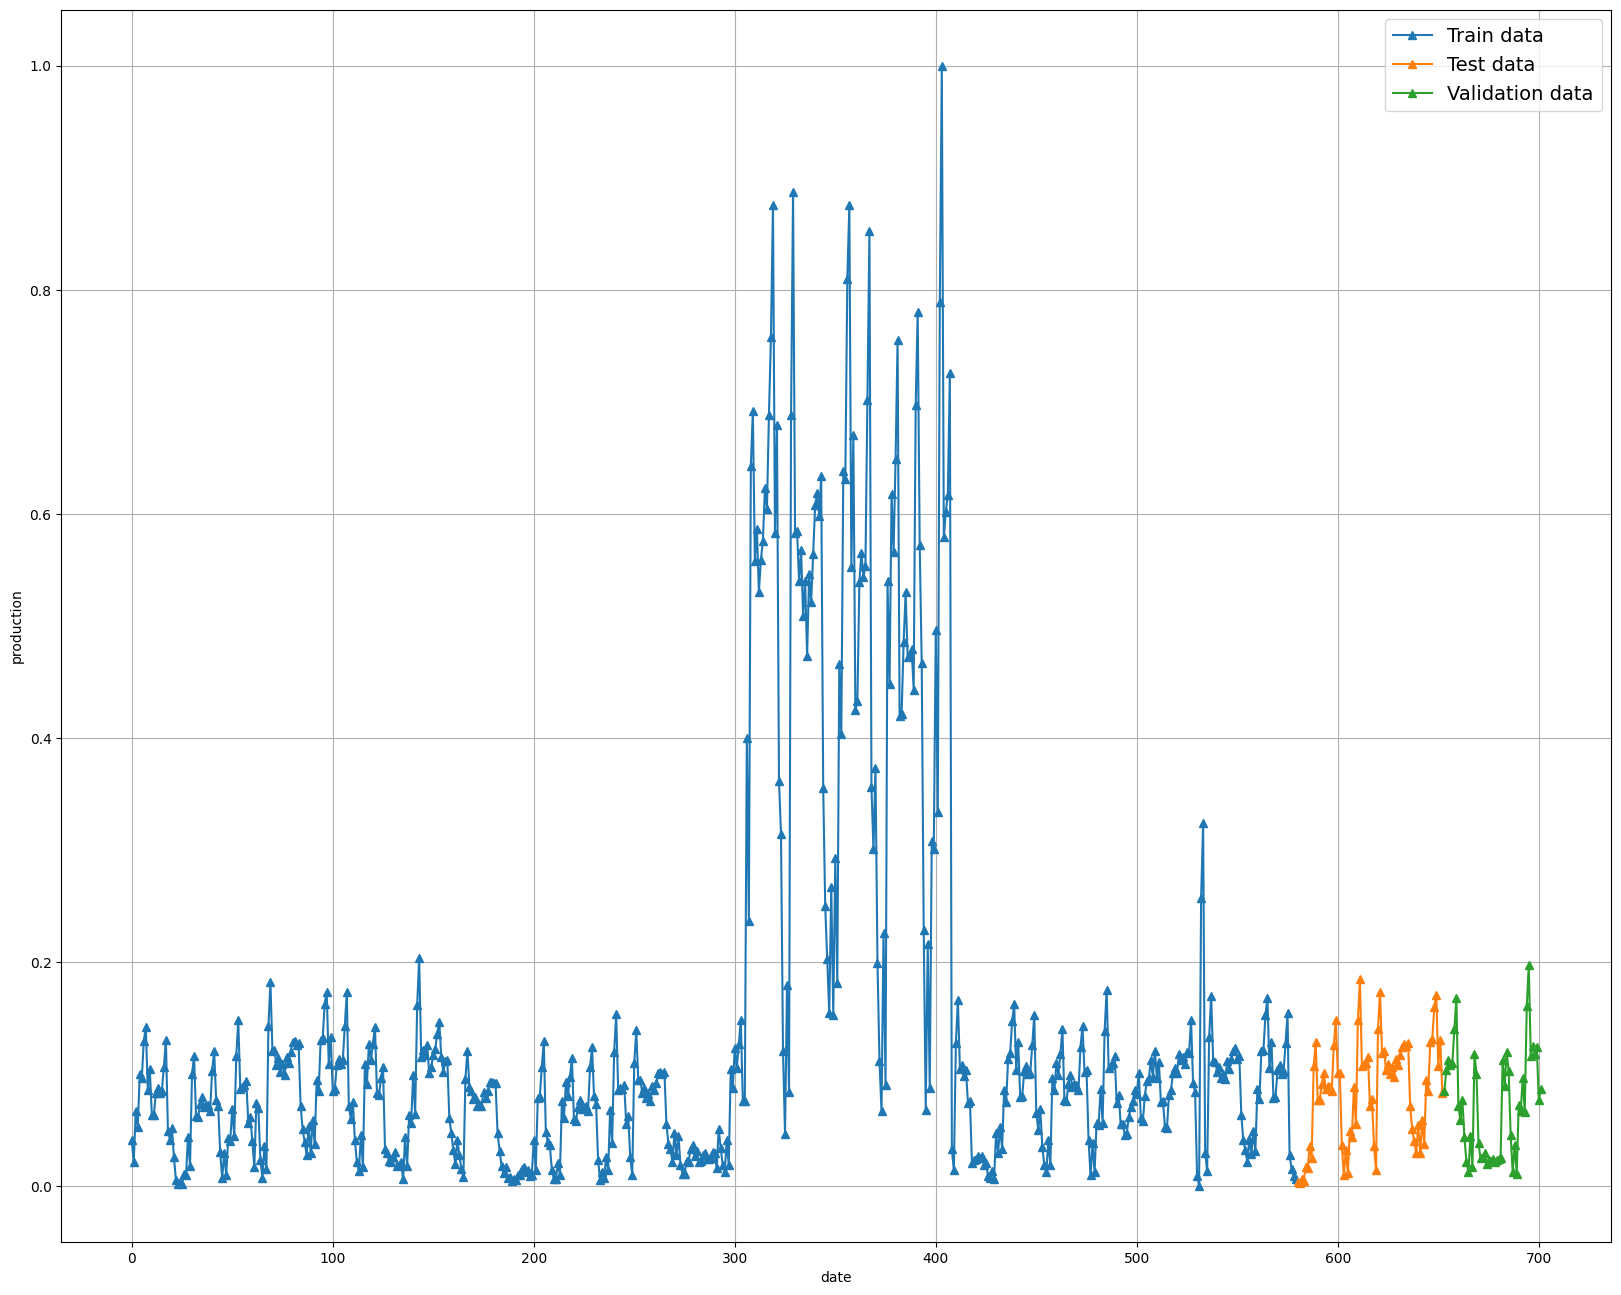

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(580, 24, 34) -> (580, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,593 (244.50 KB)

 Trainable params: 62,593 (244.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 17:18:52] [setup] RAM Tracking...
[codecarbon INFO @ 17:18:52] [setup] CPU Tracking...
[codecarbon WARNING @ 17:18:52] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 17:18:54] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 17:18:54] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 17:18:54] [setup] GPU Tracking...
[codecarbon INFO @ 17:18:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:18:54] >>> Tracker's metadata:
[codecarbon INFO @ 17:18:54]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 17:18:54]   Python version: 3.12.3
[codecarbon INFO @ 17:18:54]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:18:54]   Available RAM : 15.288 GB
[codecarbon INFO @ 17:18:54]   CPU count: 16
[codecarbon INFO @ 17:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - loss: 0.1136 - val_loss: 0.0988
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1227 - val_loss: 0.0382
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0782 - val_loss: 0.0482
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0817 - val_loss: 0.0678
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0917 - val_loss: 0.0397
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0683 - val_loss: 0.0480
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0740 - val_loss: 0.0392
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0620 - val_loss: 0.0470
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0713 - val_loss: 0.0374
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0618 - val_loss: 0.0369
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0621 - val_loss: 0.0358
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0608 - 

[codecarbon INFO @ 17:19:04] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:04] Energy consumed for all CPUs : 0.000119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:04] Energy consumed for all GPUs : 0.000010 kWh. Total GPU Power : 3.4754230756041267 W
[codecarbon INFO @ 17:19:04] 0.000144 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0471 - val_loss: 0.0336
Epoch 29/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0458 - val_loss: 0.0342
Epoch 30/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0478 - val_loss: 0.0354
Epoch 31/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0448 - val_loss: 0.0354
Epoch 32/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0433 - val_loss: 0.0344
Epoch 33/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0457 - val_loss: 0.0336
Epoch 34/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0432 - val_loss: 0.0340
Epoch 35/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0443 - val_loss: 0.0349
Epoch 36/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0422 - val_loss: 0.0351
Epoch 37/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0414 - val_loss: 0.0351
Epoch 38/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0446 - val_loss: 0.0349
Epoch 39/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0413 - val_loss:

[codecarbon INFO @ 17:19:14] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:14] Energy consumed for all CPUs : 0.000236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:14] Energy consumed for all GPUs : 0.000032 kWh. Total GPU Power : 7.910359604597619 W
[codecarbon INFO @ 17:19:14] 0.000300 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0387 - val_loss: 0.0341
Epoch 82/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0378 - val_loss: 0.0320
Epoch 83/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0382 - val_loss: 0.0312
Epoch 84/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0383 - val_loss: 0.0331
Epoch 85/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0392 - val_loss: 0.0315
Epoch 86/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0399 - val_loss: 0.0315
Epoch 87/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0384 - val_loss: 0.0316
Epoch 88/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0397 - val_loss: 0.0325
Epoch 89/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0411 - val_loss: 0.0320
Epoch 90/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0390 - val_loss: 0.0337
Epoch 91/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0394 - val_loss: 0.0303
Epoch 92/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0403 - va

[codecarbon INFO @ 17:19:24] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:24] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0358

[codecarbon INFO @ 17:19:24] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 6.434695230337172 W
[codecarbon INFO @ 17:19:24] 0.000452 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0356 - val_loss: 0.0302
Epoch 134/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0347 - val_loss: 0.0313
Epoch 135/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0354 - val_loss: 0.0299
Epoch 136/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0350 - val_loss: 0.0291
Epoch 137/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0354 - val_loss: 0.0291
Epoch 138/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0350 - val_loss: 0.0307
Epoch 139/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0363 - val_loss: 0.0308
Epoch 140/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0373 - val_loss: 0.0290
Epoch 141/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0359 - val_loss: 0.0303
Epoch 142/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0358 - val_loss: 0.0312
Epoch 143/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0351 - val_loss: 0.0316
Epoch 144/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0370 

[codecarbon INFO @ 17:19:34] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:34] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:34] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 3.317014834705362 W
[codecarbon INFO @ 17:19:34] 0.000595 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0360 - val_loss: 0.0309
Epoch 186/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0346 - val_loss: 0.0293
Epoch 187/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0340 - val_loss: 0.0284
Epoch 188/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0344 - val_loss: 0.0283
Epoch 189/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0338 - val_loss: 0.0310
Epoch 190/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0355 - val_loss: 0.0289
Epoch 191/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0336 - val_loss: 0.0280
Epoch 192/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0343 - val_loss: 0.0285
Epoch 193/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0336 - val_loss: 0.0294
Epoch 194/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0337 - val_loss: 0.0289
Epoch 195/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0347 - val_loss: 0.0288
Epoch 196/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0341

[codecarbon INFO @ 17:19:44] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:44] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:44] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 8.362523587335286 W
[codecarbon INFO @ 17:19:44] 0.000752 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0313 - val_loss: 0.0290
Epoch 241/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0331 - val_loss: 0.0277
Epoch 242/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0326 - val_loss: 0.0271
Epoch 243/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0325 - val_loss: 0.0282
Epoch 244/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0333 - val_loss: 0.0289
Epoch 245/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0325 - val_loss: 0.0283
Epoch 246/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0318 - val_loss: 0.0278
Epoch 247/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0321 - val_loss: 0.0272
Epoch 248/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0317 - val_loss: 0.0282
Epoch 249/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0325 - val_loss: 0.0275
Epoch 250/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0322 - val_loss: 0.0274
Epoch 251/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.

[codecarbon INFO @ 17:19:54] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0317

[codecarbon INFO @ 17:19:54] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:54] Energy consumed for all GPUs : 0.000105 kWh. Total GPU Power : 8.244551222861979 W
[codecarbon INFO @ 17:19:54] 0.000909 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0306 - val_loss: 0.0259
Epoch 297/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0301 - val_loss: 0.0266
Epoch 298/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0313 - val_loss: 0.0273
Epoch 299/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0305 - val_loss: 0.0273
Epoch 300/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0308 - val_loss: 0.0269


[codecarbon INFO @ 17:19:55] Energy consumed for RAM : 0.000097 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:19:55] Energy consumed for all CPUs : 0.000718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:55] Energy consumed for all GPUs : 0.000111 kWh. Total GPU Power : 29.472586936000493 W
[codecarbon INFO @ 17:19:55] 0.000926 kWh of electricity used since the beginning.


#### Ploting the loss

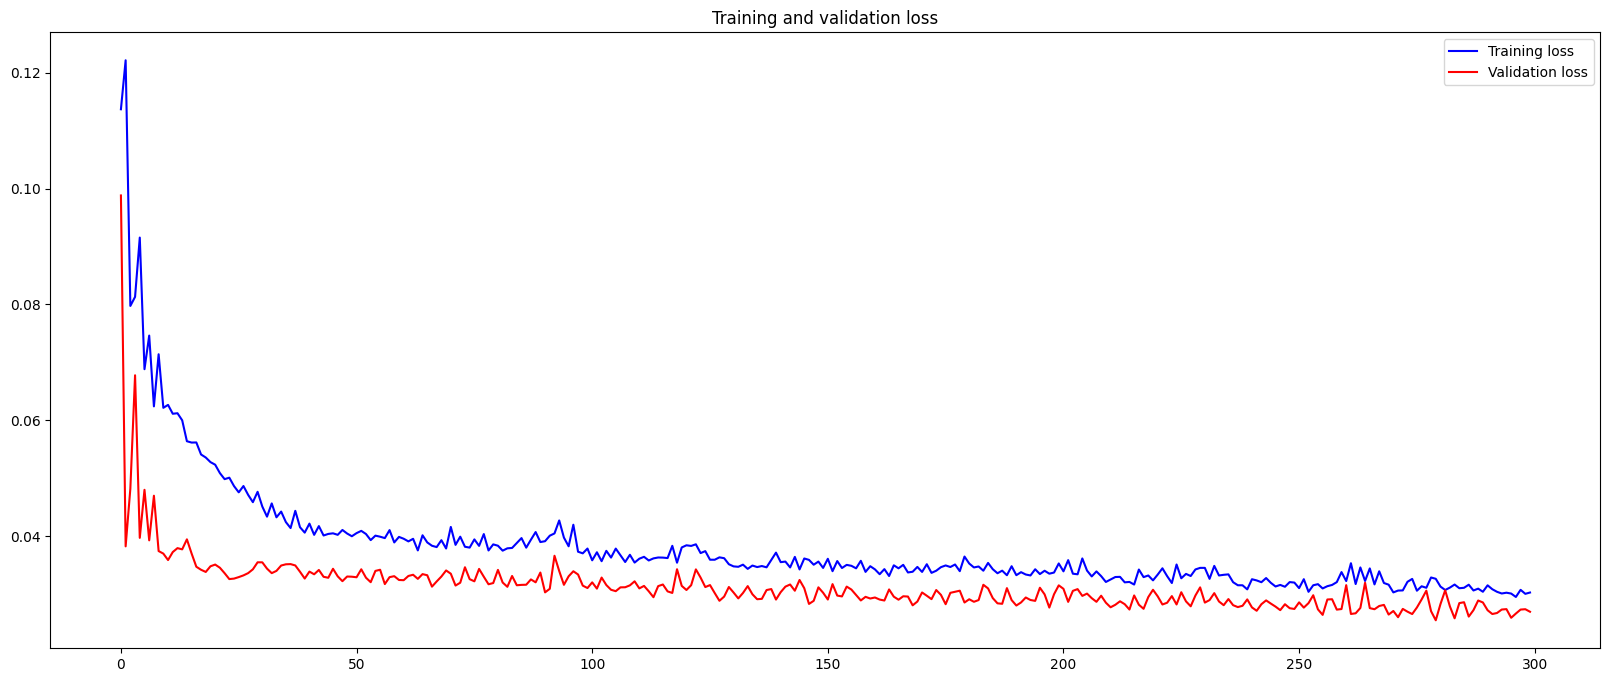

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


{'mae': np.float32(0.021105906),
 'mse': np.float32(0.0007330805),
 'r2': 0.6482774019241333}

#### Plot predictions

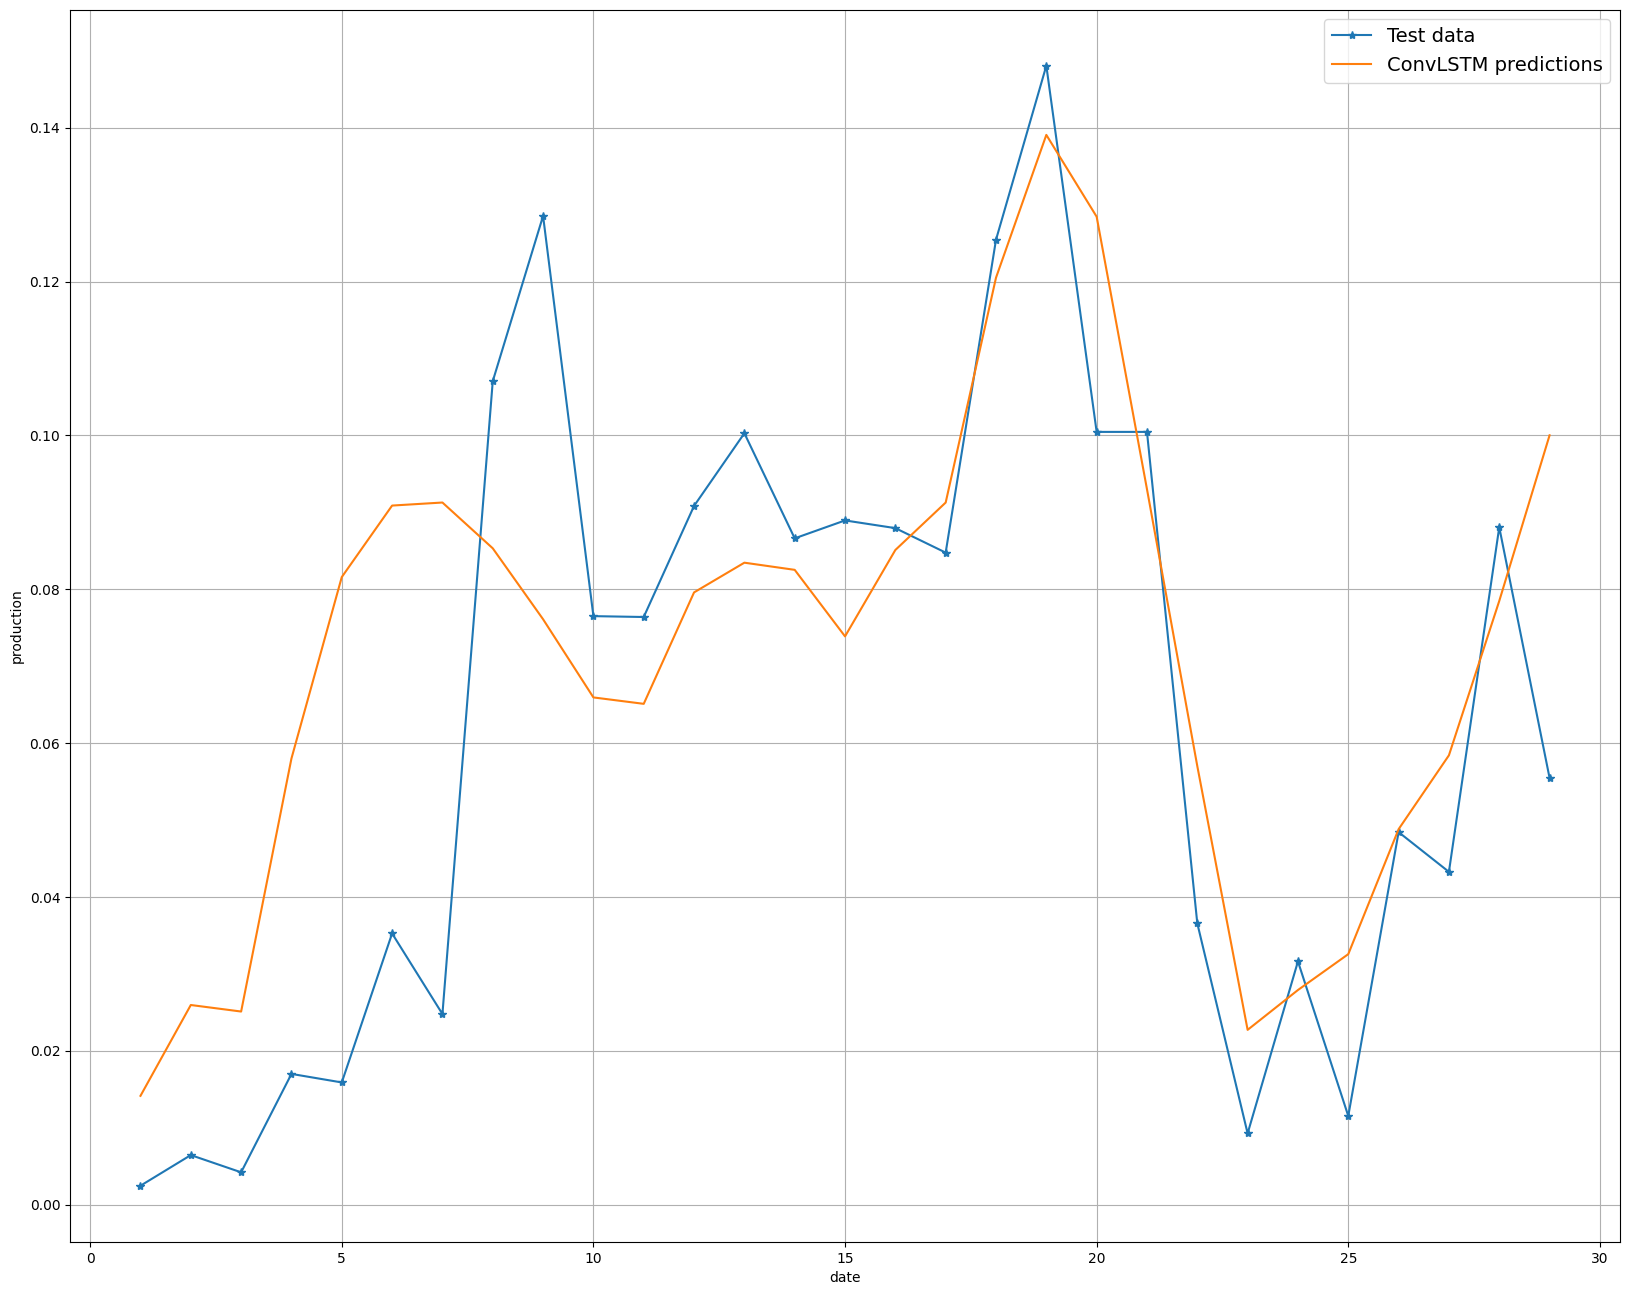

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [25]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Définition de la fonction objective pour Optuna
def objective(trial):
    # Suggestions d'hyperparamètres
    filters1 = trial.suggest_categorical('filters1', [16, 32, 64, 96, 128])
    filters2 = trial.suggest_categorical('filters2', [16, 32, 64, 96, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [1])  # Fixé à 1
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 96, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
    
    # Construction du modèle avec ces hyperparamètres
    model = Sequential([
        ConvLSTM1D(filters=filters1, kernel_size=(kernel_size,), activation='tanh',
                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        ConvLSTM1D(filters=filters2, kernel_size=(kernel_size,), activation=activation, return_sequences=False),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    
    # Entraînement rapide pour l'optimisation
    model.fit(x_train_conv_lstm, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val_conv_lstm, y_val))
    score = model.evaluate(x_val_conv_lstm, y_val, verbose=0)
    return score

# Lancer l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Affichage des meilleurs hyperparamètres trouvés
print("Best hyperparameters:", study.best_params)


[I 2025-04-02 17:19:57,204] A new study created in memory with name: no-name-5f25022e-0ddf-4815-bb93-00698cb6d120
C:\Users\yhoci\AppData\Local\Temp\ipykernel_21632\2571516682.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-02 17:20:06,612] Trial 0 finished with value: 0.04093700647354126 and parameters: {'filters1': 32, 'filters2': 96, 'kernel_size': 1, 'activation': 'tanh', 'dense_units': 32, 'learning_rate': 0.0008464587649210963}. Best is trial 0 with value

Best hyperparameters: {'filters1': 96, 'filters2': 128, 'kernel_size': 1, 'activation': 'relu', 'dense_units': 64, 'learning_rate': 0.000276833969681907}
